In [1]:
from ROOT import TFile, gDirectory
import ROOT as r
import os
import datetime
import numpy as np

Welcome to JupyROOT 6.16/00


In [2]:
%%time
#test if kernel is running

print('running')

running
CPU times: user 435 µs, sys: 427 µs, total: 862 µs
Wall time: 533 µs


# Todo

* [DONE]Add plots for number of b-tagged jets
* Check number of jets
* [DONE] extend MET plot range until no overflow 
* [DONE] fix ratio scaling on log plots


* get total sum weight of all the files (>2) # of weighted entries
* [DONE] fix the loops so that there is only one and add a flag for data/mc to do the weighting 
* [DONE] Create correction function of HT to get HT ratio ~1, make sure other rations remain unchanged, use tf1 fit or roofit
* [DONE] evaluate function of HT by making ratio comparison plots for the mc original and mc corrected
* [DONE]consider cutting off the function fit at certain HT value and flat after or adjusting bin sizes to reduce uncertainty, then fit 
* [DONE] plot signal and background on same plot and look for critical values for seperation - these are to be used as cuts later

# Cuts
* high ht - must look at signal to know
* large # of b jets (test 3 and 4)
* large # of jets
* for each cut, calcualte signal / sqrt(signal + bkg) (psudo-significance) and find cut to maximize this value 
* look at distributions by normalizing both to one (a first order approx)


# Outline of Notebook
* All function defns
* Initlalize chains and hists
* Build correction function from ht
* Refill new corrected histograms
* Make good cuts based on bkg ONLY
* Plot signal and bkg hists


Significance is ratio by which signal is ibgger than poisson flucuations

Build files into TChain

# FUNCTIONS

In [3]:
#use lum = 140
def GetWeight(lumi,tree, corr_poly = None):
    #w = lumi * 1000 * tree.weight_normalise *  tree.weight_mc *  tree.weight_pileup *tree.weight_leptonSF *  tree.weight_bTagSF_MV2c10_77 *  tree.weight_jvt
    w = ((43.5938/127.64416)*(tree.runNumber == 300000)+(36.20766/127.64416)*(tree.runNumber == 284500)+(47.8427/127.64416)*(tree.runNumber == 310000))*tree.weight_normalise*tree.weight_mc*tree.weight_pileup*tree.weight_leptonSF*tree.weight_bTagSF_MV2c10_70*127.65516*1000*(tree.nBTags_MV2c10_70>1)
    
    if corr_poly:
        w_ht_corrected = w / corr_poly.Eval(tree.HT_all)
        return w_ht_corrected
   
    else: return w

def poly_ht(func, ht):
    return func.Eval(ht)

In [4]:
def fill_hists(chain, entries, run_type, poly= None, save_hists = False, cuts =['bjets_mc70 <= 2']):
    
    for jentry in range(entries):
        nb = chain.GetEntry(jentry)
    
        if nb<=0: continue
        
        jet_pt = chain.jet_pt[0]
        met = chain.met_met
        #mu_pt = mc_chain.mu_pt
        ht_all = chain.HT_all
        bjets_mc70 = chain.nBTags_MV2c10_70
        njets = chain.nJets

        #add conditions here
        for cut in cuts:
            if eval(cut) == True: 
                continue 
        #if (bjets_mc70 < 2): continue
        
        if run_type == 'data': 
            met_data.Fill(met)
            jet_pt_data.Fill(jet_pt)
            ht_all_data.Fill(ht_all)
            bjets_data.Fill(bjets_mc70)
            njets_data.Fill(njets)

        elif run_type == 'bkg_corr':
            try:
                weight = GetWeight(140, chain, corr_poly = poly)
            except:
                print("MC corrected requires a function to exectute")
                break
                
            met_bkg_corr.Fill(met,weight)
            jet_pt_bkg_corr.Fill(jet_pt, weight)
            ht_all_bkg_corr.Fill(ht_all, weight)
            bjets_bkg_corr.Fill(bjets_mc70, weight)
            njets_bkg_corr.Fill(njets, weight)
            
        elif run_type == 'signal':
            weight = GetWeight(140, chain)
            
            met_sig.Fill(met, weight)
            ht_all_sig.Fill(ht_all, weight)
            jet_pt_sig.Fill(jet_pt, weight)
            bjets_sig.Fill(bjets_mc70, weight)
            njets_sig.Fill(njets, weight)
             
        elif run_type == 'bkg':
            weight = GetWeight(140, chain)
            
            met_bkg.Fill(met,weight)
            jet_pt_bkg.Fill(jet_pt, weight)
            ht_all_bkg.Fill(ht_all, weight)
            bjets_bkg.Fill(bjets_mc70, weight)
            njets_bkg.Fill(njets, weight)
            
    if save_hists == True:
        time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
        if run_type == 'data':
            met_data.SaveAs('met_data_' + time + '.root')
            jet_pt_data.SaveAs('jetpt_data_' + time + '.root')
            ht_all_data.SaveAs('htall_data_' + time + '.root')
            bjets_data.SaveAs('bjets_data_' + time + '.root')
            njets_data.SaveAs('njets_data_'+time+'.root')
            
        elif run_type == 'bkg_corr':
            met_bkg_corr.SaveAs('met_bkg_corr_' + time + '.root')
            jet_pt_bkg_corr.SaveAs('jetpt_bkg_corr_' + time + '.root')
            ht_all_bkg_corr.SaveAs('htall_bkg_corr_' + time + '.root')
            bjets_bkg_corr.SaveAs('bjets_bkg_corr_' + time + '.root')
            njets_bkg_corr.SaveAs('njets_bkg_corr_' + time + '.root')
            
        elif run_type == 'signal':
            met_sig.SaveAs('met_sig_' +time+'.root')
            jet_pt_sig.SaveAs('jetpt_sig_' +time+'.root')
            ht_all_sig.SaveAs('htall_sig_' +time+'.root')
            bjets_sig.SaveAs('bjets_sig_' +time+'.root')
            njets_sig.SaveAs('njets_sig_' +time+'.root')
            
        elif run_type == 'bkg':
            met_bkg.SaveAs('met_bkg_' + time + '.root')
            jet_pt_bkg.SaveAs('jetpt_bkg_' + time + '.root')
            ht_all_bkg.SaveAs('htall_bkg_' + time + '.root')
            bjets_bkg.SaveAs('bjets_bkg_' + time + '.root')
            njets_bkg.SaveAs('njets_bkg_'+time+'.root')

In [5]:
def make_ratio_hists(bkg_hist, data_hist, save_name, draw = True , log = False):
    c = r.TCanvas()
    
    rp = r.TRatioPlot(bkg_hist, data_hist)
    rp.Draw()

    if log == True:
        c.SetLogy(1)
    lower_y = rp.GetLowerRefYaxis()
    
    lower_y.SetTitle('MC/Data')
    lower_y.SetRangeUser(0,2)

    if draw == True:
        c.Draw()
        
    c.SaveAs(save_name + '.root')
    c.Close()
    r.gSystem.ProcessEvents()
    
def make_ratio_compare_hists(mc_original, mc_corr_original, data, save_name, draw = True, title = ''):
    
    c = r.TCanvas()
        
    mc = mc_original.Clone()
    mc_corr = mc_corr_original.Clone()
    
    
    mc.Divide(data)
    mc_corr.Divide(data)
    
    mc_corr.SetLineColor(4)
    mc_corr.Draw()
    mc.SetLineColor(2)
    mc.Draw("SAME")
    
    legend = r.TLegend()
    legend.AddEntry(mc, "Original Ratio")
    legend.AddEntry(mc_corr, "H^{T} Corrected Ratio")
    
    legend.Draw()
    
    mc_corr.SetTitle(title + ' H^{T}-Corrected MC Ratio')
    mc_corr.SetYTitle('MC/Data')
    mc_corr.SetXTitle('[MeV]')
    
    if draw== True:
        c.Draw()

    c.SaveAs(save_name + '.root')
    c.Close()
    r.gSystem.ProcessEvents()
    
def test_corr_fn(data_chain, mc_chain):
    
    fill_hists(data_chain, data_entries, run_type = 'data', poly = None,cuts=['bjets_mc70 != 2'])
    fill_hists(bkg_chain, bkg_entries, run_type = 'bkg', poly = None,cuts=['bjets_mc70 != 2'])
    
    #clone ht_all, call divide from data, fit divided, pass fn to corr_hists
    ht_ratio = ht_all_bkg.Clone()
    
    ht_ratio.Divide(ht_all_data)
    
    ht_ratio.Fit('pol5','S')
    
    ht_fit = ht_ratio.GetFunction('pol5')
                                                                           
                                                                         
    ht_ratio.SaveAs('fit_hist_n2'+ datetime.datetime.now().strftime("%y-%m-%d+%H_%M")+ '.root')
    
    fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = ht_fit, save_hists=True)
    
    return ht_ratio

def make_sig_bkg_stack(bkg_hist, sig_hist, save_fname , title = ''):
    stack = r.THStack()
    stack.Add(bkg_hist)
    stack.Add(sig_hist)
    
    stack.SaveAs(save_fname + '.root')
    

# Initilization

## Initilize Chains

In [6]:
%%time
filename = 'ttbar_nonallhad_HF_PhPy8_AFII_mc16a.root'
treename = 'nominal_Loose'

list_of_files = os.listdir('../data_ttbar/')
data_files = [f for f in list_of_files if 'data' in f]
bkg_files = [ 'ttbar_nonallhad_incl_PhPy8_AFII_mc16a.root', 'ttbar_nonallhad_incl_PhPy8_AFII_mc16d.root','ttbar_nonallhad_incl_PhPy8_AFII_mc16e.root',
            'ttX_mc16e.root','ttX_mc16d.root','ttX_mc16a.root',
            'vjets_Sherpa_mc16e.root','vjets_Sherpa_mc16d.root', 'vjets_Sherpa_mc16a.root',
            'singleTop_mc16e.root','singleTop_mc16d.root','singleTop_mc16a.root',
            'multiV_mc16a.root','multiV_mc16d.root','multiV_mc16e.root']

signal_files = ['4tops_Mg5Py8_AFII_mc16a.root','4tops_Mg5Py8_AFII_mc16d.root','4tops_Mg5Py8_AFII_mc16e.root']
#data_files = ['data15_AllYear.root']
#mc_files = ['ttbar_nonallhad_HF_PhPy8_AFII_mc16d.root']

data_chain = r.TChain(treename)
bkg_chain = r.TChain(treename)
signal_chain = r.TChain(treename)

for f in data_files:
    data_chain.Add('../data_ttbar/'+f)
for f in bkg_files:
    bkg_chain.Add('../data_ttbar/'+ f)
for f in signal_files:
    signal_chain.Add('../data_ttbar/'+ f)

data_entries = data_chain.GetEntries()
bkg_entries = bkg_chain.GetEntries()
signal_entries = signal_chain.GetEntries()

print(f'There are: \n{data_entries} data events \n{bkg_entries} mc events \n{signal_entries} signal events \n\n')



There are: 
3223533 data events 
23130773 mc events 
3661752 signal events 


CPU times: user 182 ms, sys: 28.7 ms, total: 211 ms
Wall time: 239 ms


## Initialize histograms

In [7]:
#####
#Set Up Code
#####

#mc_corr are mc background filled with ht-corrected weight
#mc are mc background filled with uncorrected weight
#data are data files

met_bkg = r.TH1D('met_bkg', 'E^{T}_{miss}', 100, 0, 1.2*10**6)
met_bkg_corr = r.TH1D('met_bkg_corr', 'E^{T}_{miss}', 100, 0, 1.2*10**6)
met_data = r.TH1D('met_data', 'E^T_{miss}', 100, 0, 1.2*10**6)
met_sig = r.TH1D('met_sig', 'E^T_{miss}', 100, 0, 1.2*10**6)

jet_pt_data = r.TH1D('jet_pt_data', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_bkg = r.TH1D('jet_pt_bkg', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_bkg_corr = r.TH1D('jet_pt_bkg_corr', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_sig = r.TH1D('jet_pt_sig', 'jet_{pt}', 100, 0, 2*10**6)

ht_all_bkg = r.TH1D('ht_all_bkg', 'H_{t}', 100, 0, 6000*10**3)
ht_all_bkg_corr = r.TH1D('ht_all_bkg_corr', 'H_{t}', 100, 0, 6000*10**3)
ht_all_data = r.TH1D('ht_all_data', '\H_{t}', 100, 0, 6000*10**3)
ht_all_sig = r.TH1D('ht_all_sig', '\H_{t}', 100, 0, 6000*10**3)

bjets_bkg = r.TH1D('bjets_bkg', 'Number of B Jets', 7,0,7)
bjets_bkg_corr = r.TH1D('bjets_bkg_corr', 'Number of B Jets', 7,0,7)
bjets_data = r.TH1D('bjets_data', 'Number of B Jets', 7,0,7)
bjets_sig = r.TH1D('bjets_sig', 'Number of B Jets', 7,0,7)

njets_bkg = r.TH1D('njets_bkg', 'Number of Jets', 20,0,20)
njets_data = r.TH1D('njets_data', 'Number of Jets', 20,0,20)
njets_sig = r.TH1D('njets_sig', 'Number of Jets', 20,0,20)
njets_bkg_corr = r.TH1D('njets_bkg_corr', 'Number of Jets', 20,0,20)

 # Fill histograms

In [8]:
%%time
hist_ratio = test_corr_fn(data_chain, bkg_chain)
fit_fn = hist_ratio.GetFunction('pol5')


fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True, poly = fit_fn)

In [8]:
%%time
f_ratio = r.TFile('ht_fit_correct.root')
h_ratio = f_ratio.Get('ht_all_bkg;1')
fit_fn = h_ratio.GetFunction('pol5')

fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = fit_fn, save_hists=True)
fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True, poly = fit_fn)
fill_hists(data_chain, data_entries, run_type = 'data', poly = None)

for var in ['met', 'jet_pt', 'ht_all', 'bjets', 'njets']:
    time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
    eval_string = f'make_sig_bkg_stack({var}_bkg_corr,{var}_sig, "{var}_sig_bkg_{time}", "{var}_sig_bkg_stack")'
    exec(eval_string)

CPU times: user 52min 57s, sys: 2min 39s, total: 55min 36s
Wall time: 56min 17s


Info in <TH1D::SaveAs>: ROOT file met_bkg_corr_19-04-30+19_57.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_bkg_corr_19-04-30+19_57.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_bkg_corr_19-04-30+19_57.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_bkg_corr_19-04-30+19_57.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_bkg_corr_19-04-30+19_57.root has been created
Info in <TH1D::SaveAs>: ROOT file met_sig_19-04-30+20_04.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_sig_19-04-30+20_04.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_sig_19-04-30+20_04.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_sig_19-04-30+20_04.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_sig_19-04-30+20_04.root has been created
Info in <THStack::SaveAs>: ROOT file met_sig_bkg_19-04-30+20_08.root has been created
Info in <THStack::SaveAs>: ROOT file jet_pt_sig_bkg_19-04-30+20_08.root has been cr

In [9]:
fill_hists(bkg_chain, bkg_entries, run_type = 'bkg', poly = None)

In [39]:
make_ratio_compare_hists(mc_original=ht_all_bkg, mc_corr_original=ht_all_bkg_corr, data=ht_all_data, save_name='ratio_compare_ht', title = 'H^{T}')

Info in <TCanvas::SaveAs>: ROOT file ratio_compare_ht.root has been created


AttributeError: 'TFitResult' object has no attribute 'Eval'


****************************************
Minimizer is Linear
Chi2                      =      157.885
NDf                       =           62
p0                        =     0.673831   +/-   0.00698247  
p1                        =  4.77484e-07   +/-   4.45939e-08 
p2                        = -6.98239e-13   +/-   9.71351e-14 
p3                        =  5.41601e-19   +/-   8.88988e-20 
p4                        = -1.73635e-25   +/-   3.42222e-26 
p5                        =  1.86073e-32   +/-   4.49283e-33 


Info in <TH1D::SaveAs>: ROOT file ht_fit_correct.root has been created
Info in <TH1D::SaveAs>: C++ Macro file: ht_fit_correct.png has been generated


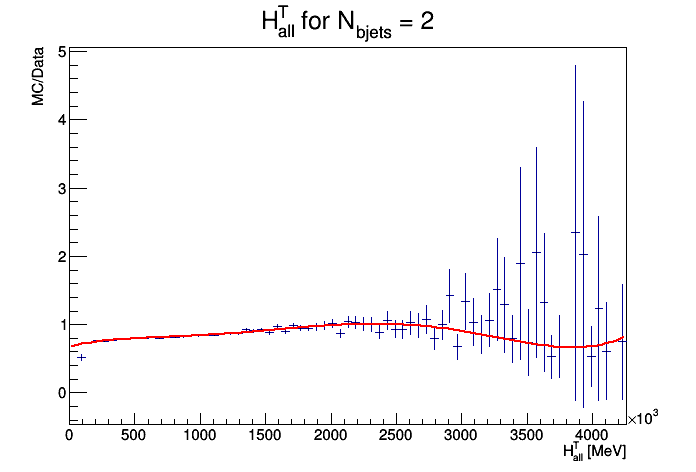

In [33]:
f_ratio = r.TFile('fit_hist_n219-04-30+11_57.root')
h_ratio = f_ratio.Get('ht_all_bkg;1')

h_test = h_ratio.Clone()
h_test.GetFunction('pol5').Delete()
h_test.SetAxisRange(0, 4250*10**3)
fit_new = h_test.Fit('pol5','S')
h_test.SetTitle('H^{T}_{all} for N_{bjets} = 2')
h_test.SetXTitle('H^{T}_{all} [MeV]')
h_test.SetYTitle('MC/Data')
h_test.SetStats(0)
h_test.SaveAs('ht_fit_correct.root')
h_test.SaveAs('ht_fit_correct.png')
c3= r.TCanvas()

h_test.Draw()


c3.Draw()

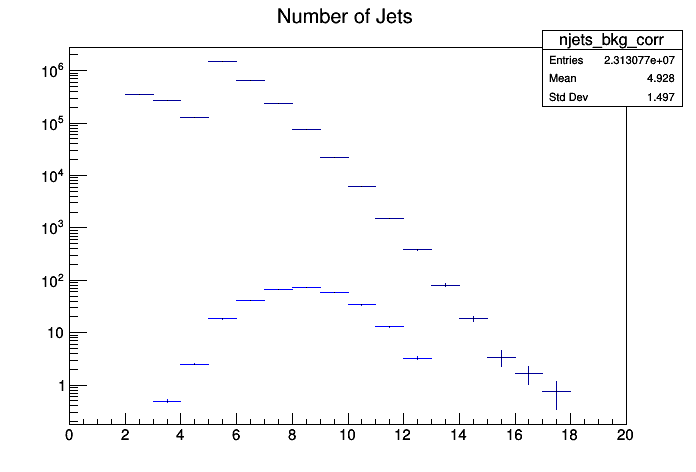

In [23]:
njets_bkg_corr.Draw()
njets_sig.SetLineColor(4)
njets_sig.Draw("SAME")
c3.SetLogy()
c3.Draw()

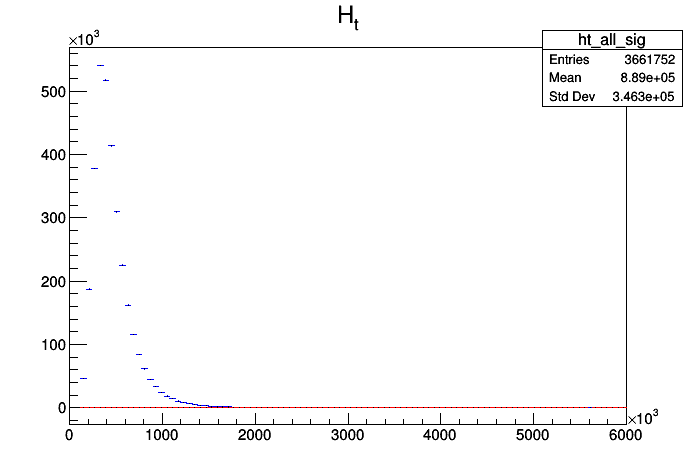

In [21]:
c_ht = r. TCanvas()
ht_all_bkg_corr.SetLineColor(4)
ht_all_bkg_corr.Draw()
ht_all_sig.SetLineColor(2)
ht_all_sig.Draw('same')
c_ht.Draw()


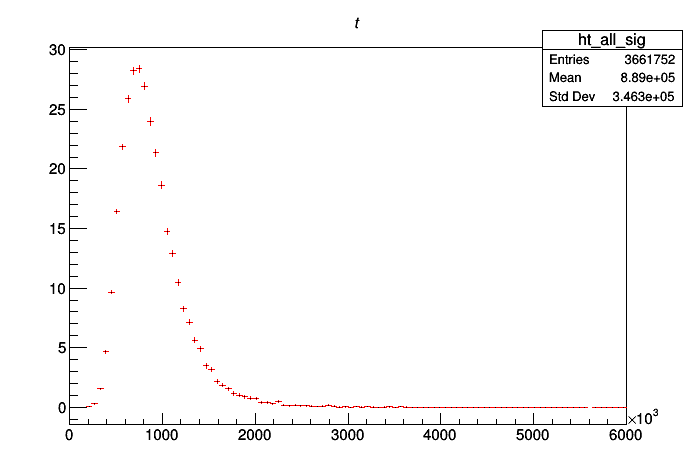

In [22]:
c_sig = r.TCanvas()
ht_all_sig.Draw()
c_sig.Draw()

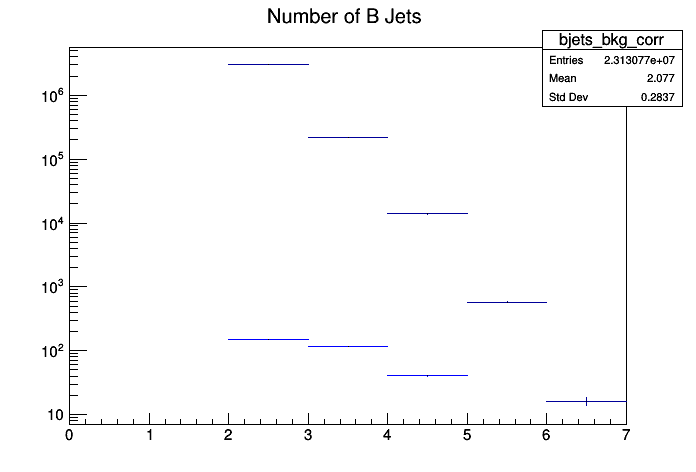

In [25]:
c4 = r.TCanvas()
bjets_bkg_corr.Draw()
bjets_sig.SetLineColor(4)
bjets_sig.Draw("SAME")
c4.SetLogy()
c4.Draw()

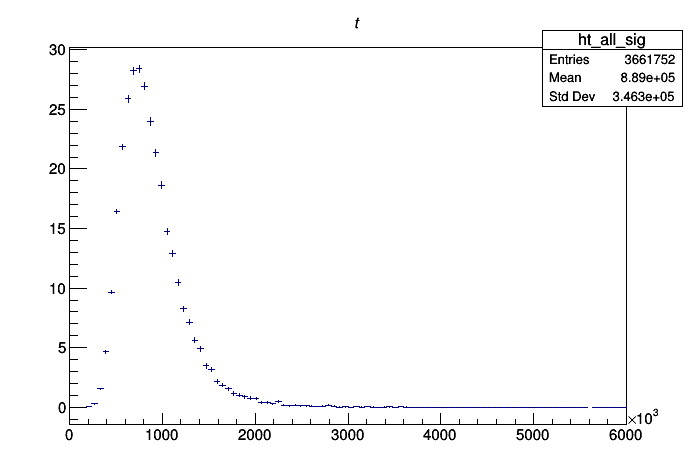

In [31]:
c = r.TCanvas()
ht_all_sig.Draw()
#ht_all_bkg.Draw("SAME")
c.Draw()

In [10]:
make_ratio_compare_hists(jet_pt_bkg, jet_pt_bkg_corr, jet_pt_data,'jet_pt_ratio', draw=False)
make_ratio_compare_hists(met_bkg, met_bkg_corr, met_data,'met_ratio', draw=False)
make_ratio_compare_hists(ht_all_bkg, ht_all_bkg_corr, ht_all_data,'ht_all_ratio', draw=False)
make_ratio_compare_hists(bjets_bkg, bjets_bkg_corr, bjets_data,'bjets_ratio', draw=False)

Info in <TCanvas::SaveAs>: ROOT file jet_pt_ratio.root has been created
Info in <TCanvas::SaveAs>: ROOT file met_ratio.root has been created
Info in <TCanvas::SaveAs>: ROOT file ht_all_ratio.root has been created
Info in <TCanvas::SaveAs>: ROOT file bjets_ratio.root has been created


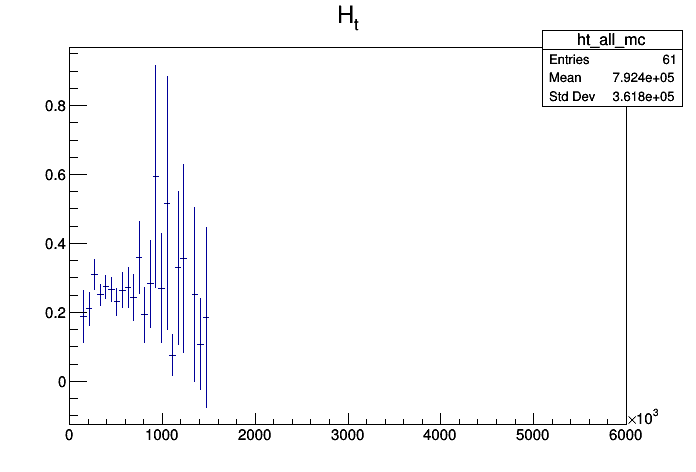

In [11]:
c_corr = r.TCanvas()


ht_ratio = ht_all_mc.Clone()
    
ht_ratio.Divide(ht_all_data)
        
ht_ratio.Draw()
    
c_corr.Draw()

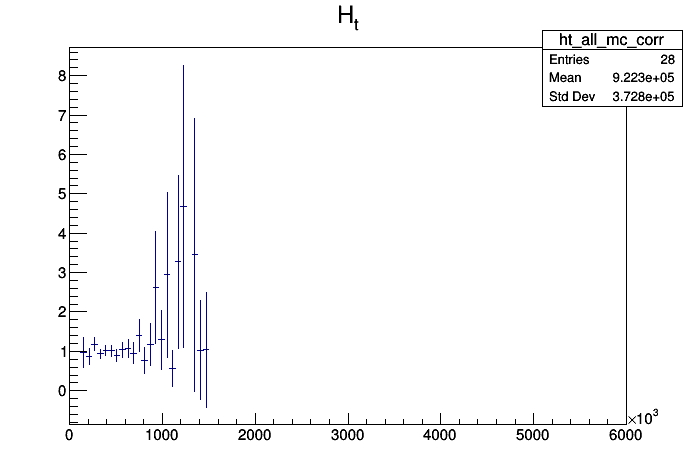

In [13]:
c_c = r.TCanvas()


ht_ratio_corr = ht_all_mc_corr.Clone()
    
ht_ratio_corr.Divide(ht_all_data)
        
ht_ratio_corr.Draw()
    
c_c.Draw()

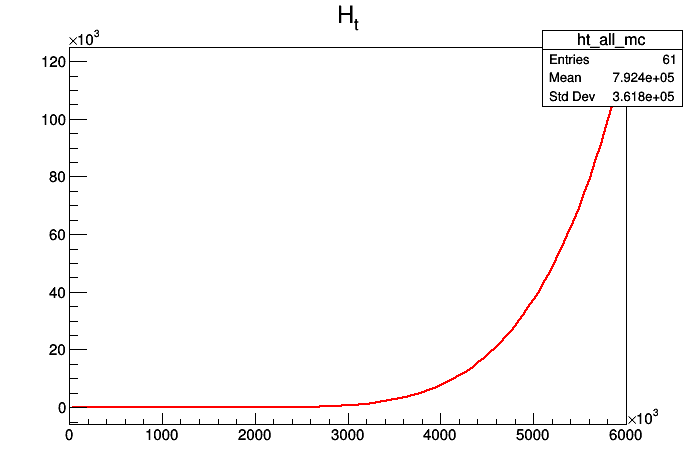

In [10]:
c2 = r.TCanvas()
ht_all_mc.Draw()
c2.Draw()

# Plot and draw testing area

## Jet pt

CPU times: user 138 ms, sys: 28.8 ms, total: 167 ms
Wall time: 256 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 30 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file jet_pt_ttbar.root has been created


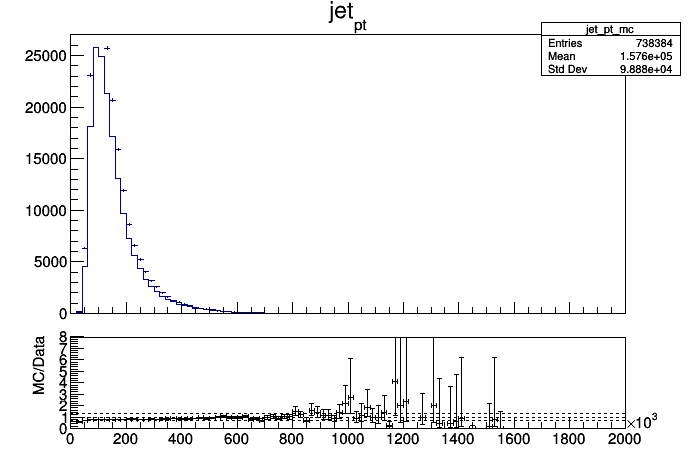

In [9]:
%%time
###
#Wrap Up
####
c_jet_pt = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_jet_pt = r.TRatioPlot(jet_pt_mc, jet_pt_data)
rp_jet_pt.Draw()
jet_pt_upper_pad = rp_jet_pt.GetUpperPad()

lower_y_jetpt = rp_jet_pt.GetLowerRefYaxis()
rp_jet_pt.GetLowerPad().SetLogy(0)
lower_y_jetpt.SetTitle('MC/Data')
lower_y_jetpt.SetRangeUser(0,8)


c_jet_pt.Draw()
c_jet_pt.SaveAs('jet_pt_ttbar.root')

# ht 

CPU times: user 84.4 ms, sys: 41.5 ms, total: 126 ms
Wall time: 224 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 46 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file ht_all_ttbar.root has been created


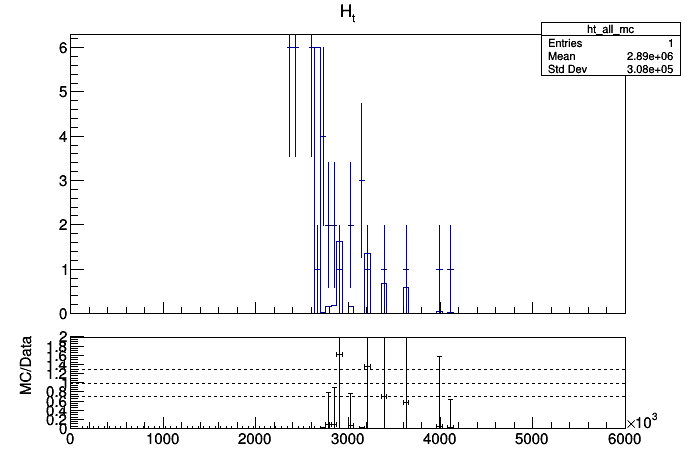

In [19]:
%%time
###
#Wrap Up
####
c_ht = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_ht = r.TRatioPlot(ht_all_mc, ht_all_data)
rp_ht.Draw()
#ht_upper_pad = rp_ht.GetUpperPad()
#ht_log_upper_pad.SetLogy(1)
lower_y_ht_log = rp_ht.GetLowerRefYaxis()
#rp_ht.GetLowerPad().SetLogy(0)
lower_y_ht_log.SetTitle('MC/Data')
lower_y_ht_log.SetRangeUser(0,2)


c_ht.Draw()
c_ht.SaveAs('ht_all_ttbar.root')

## met

CPU times: user 8.25 ms, sys: 2.38 ms, total: 10.6 ms
Wall time: 11.1 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 35 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file met_ttbar.root has been created


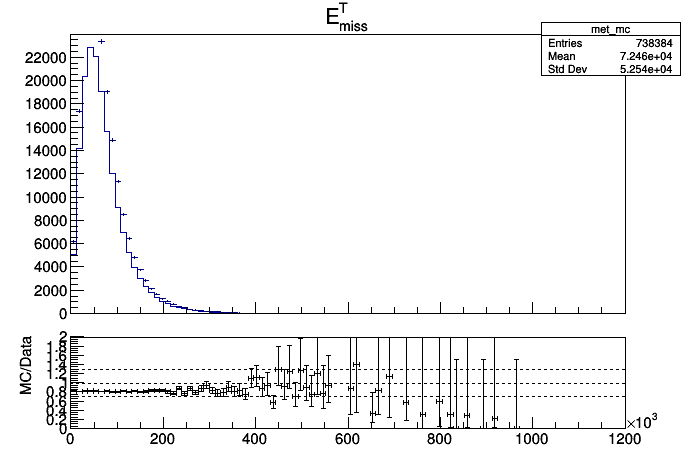

In [14]:
%%time
###
#Wrap Up
####
c_met = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_met = r.TRatioPlot(met_mc, met_data)
rp_met.Draw()
met_upper_pad = rp_met.GetUpperPad()
#met_upper_pad.SetLogy(1)
lower_y_met = rp_met.GetLowerRefYaxis()
#rp_met.GetLowerPad().SetLogy(0)
lower_y_met.SetTitle('MC/Data')
lower_y_met.SetRangeUser(0,2)


c_met.Draw()
c_met.SaveAs('met_ttbar.root')

## bjets

CPU times: user 7.64 ms, sys: 1.91 ms, total: 9.56 ms
Wall time: 11.2 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 3 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file bjets_bjets3.root has been created


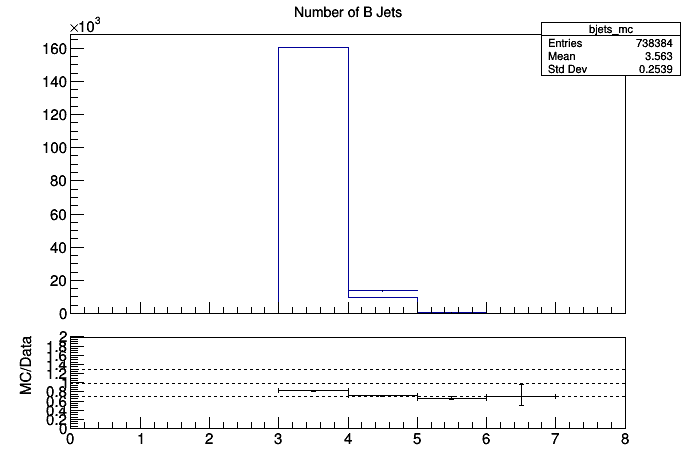

In [15]:
%%time
###
#Wrap Up
####
c_bjets = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_bjets = r.TRatioPlot(bjets_mc, bjets_data)
rp_bjets.Draw()

lower_y_bjets = rp_bjets.GetLowerRefYaxis()
#rp_met.GetLowerPad().SetLogy(0)
lower_y_bjets.SetTitle('MC/Data')
lower_y_bjets.SetRangeUser(0,2)


c_bjets.Draw()
c_bjets.SaveAs('bjets_bjets3.root')

In [39]:
make_ratio_hists(met_bkg, met_data, 'met_test', draw=True)

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 94 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file met_test.root has been created


In [11]:
def find_opt_cut(file):
    f = r.TFile(file)
    stack = f.Get(";1")
    
    f.Close()
    hists = stack.GetHists()
    
    bkg, sig = hists
    bkg.SetDirectory(0)
    sig.SetDirectory(0)
    
    
    bins = bkg.GetNbinsX()
    
    best_cut = 0
    best_min = None
    
    plot_cut = []
    plot_min = []
    for min_bin in range(bins):
        #for max_bin in bins:
        max_bin = bins
        bkg_int = bkg.Integral(min_bin, max_bin)
        sig_int = sig.Integral(min_bin, max_bin)

        cut = sig_int / np.sqrt(sig_int + bkg_int)

        plot_cut.append(cut)
        plot_min.append(bkg.GetXaxis().GetBinLowEdge(min_bin))
        if cut > best_cut:
            best_cut = cut
            best_min = min_bin
            
    with open(file+'_output.txt', 'w') as out_file:
        for s in zip(plot_min, plot_cut):
            out_file.write(str(s[0])+ ',' + str(s[1])+ '\n')
    
    print('Cut at', bkg.GetXaxis().GetBinLowEdge(best_min),'for significance =', best_cut)


In [41]:
find_opt_cut('njets_sig_bkg_19-04-30+20_08.root')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [42]:
find_opt_cut('bjets_sig_bkg_19-04-30+20_08.root')

Cut at 4.0 for significance = 0.3723963085406721


In [43]:
find_opt_cut('jet_pt_sig_bkg_19-04-30+20_08.root')

Cut at 140000.0 for significance = 0.22385796813294248


In [44]:
find_opt_cut('ht_all_sig_bkg_19-04-30+20_08.root')

Cut at 720000.0 for significance = 0.355893282592998


In [45]:
find_opt_cut('met_sig_bkg_19-04-30+20_08.root')

Cut at 48000.0 for significance = 0.17466278367867946


In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
def plot_cut_efficiency(file, unit="", title="", save_name=None):
    data = pd.read_csv(file, header = None)
    plt.plot(data[0], data[1])
    plt.xlabel('Cut Value' + ' ['+ unit+']')
    plt.ylabel('Significance')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    locs, labels = plt.xticks()
    
    
    if unit=='MeV'or unit =='GeV':
        loc_new = [int(loc/1000) for loc in locs]
        plt.xticks(locs, loc_new)
    
    
    if save_name:
        plt.savefig(save_name + '.png')

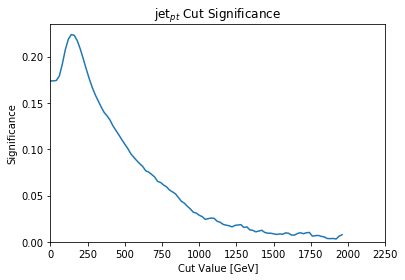

In [60]:
plot_cut_efficiency('jet_pt_sig_bkg_19-04-30+20_08.root_output.txt',title = r'jet$_{pt}$ Cut Significance',unit = 'GeV', save_name='jetpt_signif1' )

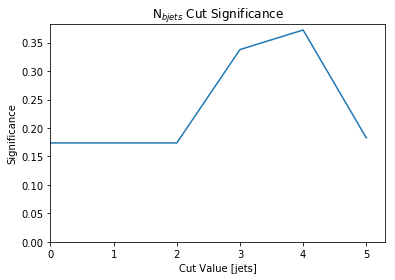

In [61]:
plot_cut_efficiency('bjets_sig_bkg_19-04-30+20_08.root_output.txt',title = r'N$_{bjets}$ Cut Significance', unit='jets',save_name='bjets_signif1')

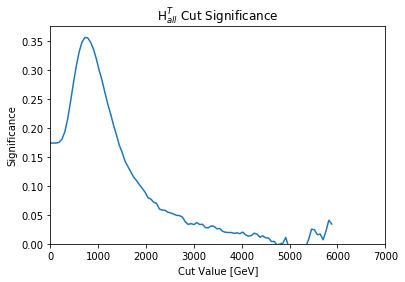

In [62]:
plot_cut_efficiency('ht_all_sig_bkg_19-04-30+20_08.root_output.txt',title = r'H$^T_{all}$ Cut Significance', unit='GeV',save_name='ht_signif1')

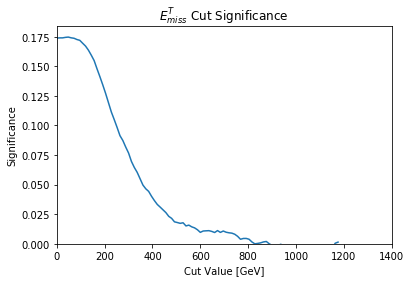

In [63]:
plot_cut_efficiency('met_sig_bkg_19-04-30+20_08.root_output.txt', title = r'$E^T_{miss}$ Cut Significance',unit = 'GeV', save_name='met_signif1')

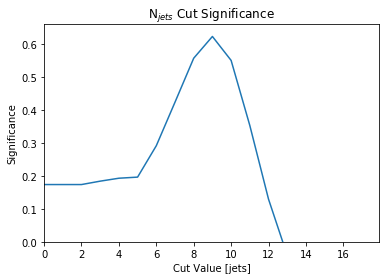

In [64]:
plot_cut_efficiency('njets_sig_bkg_19-04-30+20_08.root_output.txt', unit = 'jets', title = r'N$_{jets}$ Cut Significance', save_name='njets_signif1')

# AFTER FIRST CUT (CUT ON NJETS)

In [9]:
f_ratio = r.TFile('ht_fit_correct.root')
h_ratio = f_ratio.Get('ht_all_bkg;1')
fit_fn = h_ratio.GetFunction('pol5')

cut1 = ['bjets_mc70 <=2', 'njets <9']
fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True, cuts = cut1, poly=fit_fn)
fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = fit_fn, save_hists=True, cuts=cut1)

Info in <TH1D::SaveAs>: ROOT file met_sig_19-04-30+22_59.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_sig_19-04-30+22_59.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_sig_19-04-30+22_59.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_sig_19-04-30+22_59.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_sig_19-04-30+22_59.root has been created
Info in <TH1D::SaveAs>: ROOT file met_bkg_corr_19-04-30+23_46.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_bkg_corr_19-04-30+23_46.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_bkg_corr_19-04-30+23_46.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_bkg_corr_19-04-30+23_46.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_bkg_corr_19-04-30+23_46.root has been created


In [12]:
find_opt_cut('njets_bkg_corr_19-04-30+23_46.root')

AttributeError: 'TObject' object has no attribute 'GetHists'

In [7]:
def make_bkg_sig_from_file(file):
    f = r.TFile(file)
    stack = f.Get(";1")
    
    f.Close()
    hists = stack.GetHists()
    
    bkg, sig = hists
    bkg.SetDirectory(0)
    sig.SetDirectory(0)
    
    bkg.Draw()
    bkg.SetLineColor(4)
    sig.Draw("SAME")
    sig.SetLineColor(2)
    
    leg = r.TLegend()
    leg.AddEntry(bkg, 'Background')
    leg.AddEntry(sig, 'Signal')

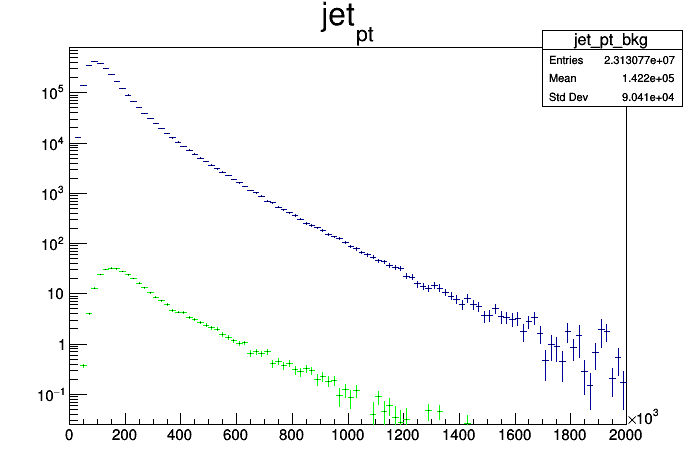

In [21]:
file = 'jet_pt_sig_bkg_19_04_17+19_30.root'
f = r.TFile(file)
stack = f.Get(";1")

f.Close()
hists = stack.GetHists()

bkg, sig = hists
bkg.SetDirectory(0)
sig.SetDirectory(0)

c = r.TCanvas()
bkg.Draw()

bkg.SetLineColor(4)
sig.Draw("SAME")
sig.SetLineColor(2)

bkg.SetTitle('jet_{pt} Log Signal and Background')
bkg.SetXTitle('[MeV]')
bkg.SetYTitle('Events')

c.SetLogy()
c.Draw()
